# Import

In [2]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro

import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [3]:
#import data

import matplotlib.pyplot as plt
SATED_DECONV = np.load('../Data/predictions_fullTrace_sated.npy', allow_pickle=True)
ANG_STIM_DATA = loadmat('../Data/metadata_deconv/stimAngle_sated.mat', simplify_cells=True)
SF_STIM_DATA  = loadmat('../Data/metadata_deconv/stimSpatFreq_sated.mat', simplify_cells=True)
SATED_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
SATED_SF    = SF_STIM_DATA['stimSpatFreq_arossAnimals']

FOOD_RESTRICTED_SATED = [1,2,3,6,7,8,11,12]
CONTROL_SATED         = [0,4,5,9,10,13]

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



670752


# Animal 0 SF 0 Run

In [46]:
# Animal 0 SF 0 
TEST_DATA = resort_preprocessing(SATED_DECONV,SATED_ANGLE,SATED_SF,0)[:,:,0, :,40:80]
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
N,C,K = TEST_RESPONSE.shape

SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]



# # Animal 0 Best SF
# TEST_DATA = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, 0)[:, :, :, :, 40:80]

# best_test = np.zeros((TEST_DATA.shape[0], TEST_DATA.shape[1], TEST_DATA.shape[3], TEST_DATA.shape[4]))
# for i in range(TEST_DATA.shape[0]):
#     best_sf = np.nanargmax(np.nanmean(TEST_DATA[i, :, :, :, :], axis=(0, 2, 3))).astype('int')
#     best_test[i, :, :, :] = TEST_DATA[i, :, best_sf, :, :]

# TEST_RESPONSE = np.nanmean(best_test, axis=-1)  # Shape N x C x K
# good_trials = ~jnp.isnan(TEST_RESPONSE).any(axis=(1, 2))   # shape (K,)
# TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
# K = TEST_RESPONSE.shape[0]
# print(TEST_RESPONSE.shape)

# Animal 0 BEST SF Round

In [36]:
# Animal 0 Best SF
TEST_DATA = resort_preprocessing(SATED_DECONV, SATED_ANGLE, SATED_SF, 0)[:, :, :, :, 40:80]

best_test = np.zeros((TEST_DATA.shape[0], TEST_DATA.shape[1], TEST_DATA.shape[3], TEST_DATA.shape[4]))
for i in range(TEST_DATA.shape[0]):
    best_sf = np.nanargmax(np.nanmean(TEST_DATA[i, :, :, :, :], axis=(0, 2, 3))).astype('int')
    best_test[i, :, :, :] = TEST_DATA[i, :, best_sf, :, :]

TEST_RESPONSE = np.nanmean(best_test, axis=-1)  # Shape N x C x K
good_trials = ~jnp.isnan(TEST_RESPONSE).any(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
print(TEST_RESPONSE.shape)

(113, 12, 11)


/tmp/ipykernel_36721/3745337128.py:9: RuntimeWarning: Mean of empty slice
  TEST_RESPONSE = np.nanmean(best_test, axis=-1)  # Shape N x C x K


# Codex Try

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
from numpyro import optim

import models
import inference
import utils

def optimize_lrd_hyperparams(
    y_full,
    *,
    train_trial_prop: float = 0.8,
    train_condition_prop: float = 0.8,
    n_draws: int = 200,
    n_vi_steps: int = 2000,
    n_mc: int = 32,
    V_scale: float = 1e-1,
    seed: int = 0,
):
    """
    Random search for WishartLRDProcess hyperparameters.
    y_full: array shaped (trials K, conditions C, neurons N).
    Returns: dict with best_hp, best_ll, and per-draw history.
    """
    K, C, N = y_full.shape
    x_full = jnp.arange(C)[:, None]
    period = C

    # Single split to curb overfitting (train vs validation conditions/trials)
    data = utils.split_data(
        x=x_full,
        y=y_full,
        train_trial_prop=train_trial_prop,
        train_condition_prop=train_condition_prop,
        seed=seed,
    )
    x_tr, y_tr, _, _, x_te, y_te, *_ = data
    x_tr, x_te = x_tr.reshape(-1), x_te.reshape(-1)  # flatten condition axis

    # def _logu(key, low, high, dtype=jnp.float32):
    #     log_low = jnp.array(low, dtype)
    #     log_high = jnp.array(high, dtype)
    #     return jnp.exp(
    #         jax.random.uniform(
    #             key,
    #             shape=(),
    #             minval=log_low,
    #             maxval=log_high,
    #             dtype=dtype,
    #         )
    #     )
    def _logu(key, low, high):
        return jnp.exp(
            jax.random.uniform(key, (), minval=jnp.log(low), maxval=jnp.log(high)))

    def sample_hp(key):
        k1, k2, k3, k4, k5, k6, k7 = jax.random.split(key, 7)
        return {
            "l_gp_a": _logu(k1, 0.2, 3.0),
            "g_gp_a": _logu(k2, 1e-5, 1e-3),
            "b_gp_a": _logu(k3, 0.05, 2.0),
            "l_wp_a": _logu(k4, 0.07, 3.0),
            "g_wp_a": _logu(k5, 1e-5, 1e-1),
            "b_wp_a": _logu(k6, 0.1, 5.0),
            "p": int(jax.random.randint(k7, (), 0, 6)),  # 0..5 inclusive
        }

    def evaluate(key, hp):
        # Kernels
        K_gp = lambda a, b: hp["g_gp_a"] * (a == b) + hp["b_gp_a"] * jnp.exp(
            -jnp.sin(jnp.pi * jnp.abs(a - b) / period) ** 2 / hp["l_gp_a"]
        )
        K_wp = lambda a, b: hp["g_wp_a"] * (a == b) + hp["b_wp_a"] * jnp.exp(
            -jnp.sin(jnp.pi * jnp.abs(a - b) / period) ** 2 / hp["l_wp_a"]
        )

        # Model
        gp = models.GaussianProcess(kernel=K_gp, N=N)
        wp = models.WishartLRDProcess(
            kernel=K_wp,
            P=int(hp["p"]),
            V=V_scale * jnp.eye(N),
            optimize_L=True,
        )

        # Initialize L from train covariance for stability
        y_flat = y_tr.reshape(-1, N)
        y_flat = y_flat - y_flat.mean(0, keepdims=True)
        Sigma_bar = (y_flat.T @ y_flat) / (y_flat.shape[0] - 1)
        eps = 1e-3 * jnp.trace(Sigma_bar) / N
        wp.L = jnp.linalg.cholesky(Sigma_bar + eps * jnp.eye(N))

        lik = models.NormalConditionalLikelihood(N)
        joint = models.JointGaussianWishartProcess(gp, wp, lik)

        # Variational inference
        guide = inference.VariationalNormal(joint.model)
        optimizer = optim.Adam(1e-2)
        k_vi, k_mc = jax.random.split(key)

        try:
            guide.infer(optimizer, x_tr, y_tr, n_vi_steps, key=k_vi)
            joint.update_params(guide.posterior)
            posterior = models.NormalGaussianWishartPosterior(joint, guide, x_tr)
        except Exception:
            return -jnp.inf  # invalid hyperparam setting

        y_obs = y_te["x_test"]

        def one_draw(rng):
            with numpyro.handlers.seed(rng_seed=rng):
                mu, Sigma, _ = posterior.sample(x_te)
            return lik.log_prob(y_obs, mu, Sigma).mean()

        mc_keys = jax.random.split(k_mc, n_mc)
        return jax.vmap(one_draw)(mc_keys).mean()

    # Random search loop
    key = jax.random.PRNGKey(seed)
    best = {"hp": None, "ll": -jnp.inf}
    history = []

    for _ in range(n_draws):
        key, k_hp, k_eval = jax.random.split(key, 3)
        hp = sample_hp(k_hp)
        score = float(evaluate(k_eval, hp))
        history.append({"hp": hp, "ll": score})
        if score > best["ll"]:
            best = {"hp": hp, "ll": score}

    return {**best, "history": history}
# Optimize hyperparameters


result = optimize_lrd_hyperparams(
    TEST_RESPONSE,
    train_trial_prop=0.8,
    train_condition_prop=0.8,
    n_draws=50,
    n_vi_steps=15000,
    n_mc=32,
    V_scale=1e-1,
    seed=SEED,
)


 24%|██▍       | 3627/15000 [00:20<01:04, 176.24it/s, init loss: 14142114809.6721, avg. loss [2251-3000]: 1986097.2602]


KeyboardInterrupt: 

: 

In [10]:
# visualise hyperparameter search results


AttributeError: module 'visualizations' has no attribute 'plot_hyperparam_search'

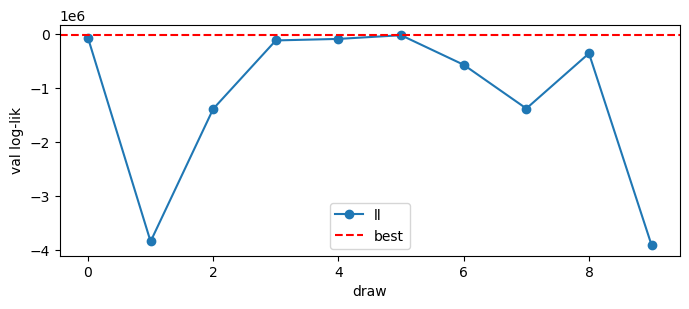

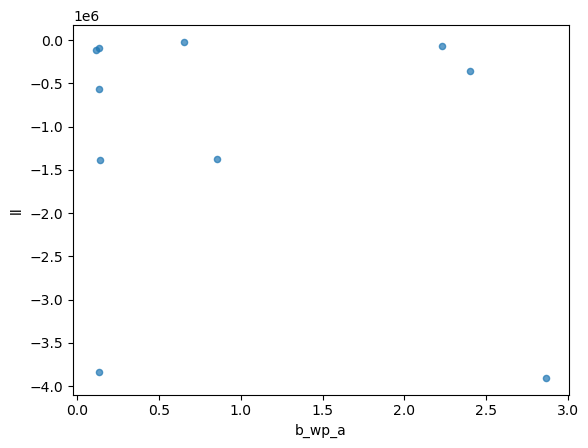

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# `result` is what optimize_lrd_hyperparams returned
hist_df = pd.DataFrame([
    {**h["hp"], "ll": h["ll"]} for h in result["history"]
])

# Simple trace of scores
ax = hist_df["ll"].plot(marker="o", figsize=(8,3))
ax.set_xlabel("draw")
ax.set_ylabel("val log-lik")
ax.axhline(result["ll"], color="red", ls="--", label="best")
ax.legend()
plt.show()

# Scatter a couple of hyperparams vs score
hist_df.plot.scatter(x="b_wp_a", y="ll", alpha=0.7)
plt.show()



In [80]:
topk = hist_df.sort_values("ll", ascending=False).head(5)
print(topk[["ll", "l_wp_a", "b_wp_a", "g_wp_a", "p"]])
best_hp = result["hp"]


              ll               l_wp_a               b_wp_a  \
5  -19422.988281  0.46683647128430666   0.6529558990948647   
0  -66458.160295   1.0368991974795063    2.232220621308216   
4  -87565.371637  0.09613689525485852   0.1340786988265652   
3 -115778.736373  0.20383007668719072  0.11174839099238852   
8 -355170.856597    1.441014940802769   2.4025173379224083   

                  g_wp_a  p  
5   0.005567427241606849  1  
0   0.058998684335986304  1  
4    0.07704277266538927  0  
3   0.001879205019710842  1  
8  0.0057997164167902055  0  


In [81]:
import json, numpy as np, jax.numpy as jnp, jax

def to_jsonable(x):
    if x is None or isinstance(x, (bool, int, float, str)):
        return x
    if isinstance(x, np.generic):
        return x.item()
    if isinstance(x, (jax.Array, jnp.ndarray, np.ndarray)):
        arr = np.asarray(x)
        return arr.item() if arr.shape == () else arr.tolist()
    if isinstance(x, dict):
        return {str(k): to_jsonable(v) for k, v in x.items()}
    if isinstance(x, (list, tuple, set)):
        return [to_jsonable(v) for v in x]
    return str(x)

payload = {
    "best_hp": to_jsonable(best_hp),
    "best_ll": to_jsonable(result["ll"]),
}

with open("hp_runs/best_lrd_3.json", "w") as f:
    json.dump(payload, f, indent=2)

hist_df.to_csv("hp_runs/search_history_3.csv", index=False)

In [ ]:


# ---------------------------------------------------------------------
# 1) Load best hyperparameters (from the file you saved earlier)
with open("hp_runs/best_lrd_3.json") as f:
    saved = json.load(f)
best_hp = saved["best_hp"]

# ---------------------------------------------------------------------
# 2) Prepare data/split (example: using TEST_RESPONSE already in memory)
K, C, N = TEST_RESPONSE.shape
x_full = jnp.arange(C)[:, None]
period = C

data = utils.split_data(
    x=x_full,
    y=TEST_RESPONSE,
    train_trial_prop=0.8,
    train_condition_prop=0.8,
    seed=0,  # set as you like
)
x_tr, y_tr, _, _, x_te, y_te, *_ = data
x_tr, x_te = x_tr.reshape(-1), x_te.reshape(-1)

# ---------------------------------------------------------------------
# 3) Build model with best hyperparameters
K_gp = lambda a, b: best_hp["g_gp_a"] * (a == b) + best_hp["b_gp_a"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / period) ** 2 / best_hp["l_gp_a"]
)
K_wp = lambda a, b: best_hp["g_wp_a"] * (a == b) + best_hp["b_wp_a"] * jnp.exp(
    -jnp.sin(jnp.pi * jnp.abs(a - b) / period) ** 2 / best_hp["l_wp_a"]
)

gp = models.GaussianProcess(kernel=K_gp, N=N)
wp = models.WishartLRDProcess(
    kernel=K_wp,
    P=int(best_hp["p"]),
    V=1e-1 * jnp.eye(N),
    optimize_L=True,
)

# Initialize L from train covariance for numerical stability
y_flat = y_tr.reshape(-1, N)
y_flat = y_flat - y_flat.mean(0, keepdims=True)
Sigma_bar = (y_flat.T @ y_flat) / (y_flat.shape[0] - 1)
eps = 1e-3 * jnp.trace(Sigma_bar) / N
wp.L = jnp.linalg.cholesky(Sigma_bar + eps * jnp.eye(N))

lik = models.NormalConditionalLikelihood(N)
joint = models.JointGaussianWishartProcess(gp, wp, lik)

# ---------------------------------------------------------------------
# 4) Variational inference
guide = inference.VariationalNormal(joint.model)
optimizer = optim.Adam(1e-2)
vi_key = jax.random.PRNGKey(0)  # set your seed
guide.infer(optimizer, x_tr, y_tr, n_iter=50000, key=vi_key)
joint.update_params(guide.posterior)

# Posterior object: use to sample / predict later
posterior = models.NormalGaussianWishartPosterior(joint, guide, x_tr)

# ---------------------------------------------------------------------
# 5) Example: evaluate on held-out conditions/trials
y_obs = y_te["x_test"]

def one_draw(rng):
    with numpyro.handlers.seed(rng_seed=rng):
        mu, Sigma, _ = posterior.sample(x_te)
    return lik.log_prob(y_obs, mu, Sigma).mean()

mc_keys = jax.random.split(jax.random.PRNGKey(1), 32)
val_ll = jax.vmap(one_draw)(mc_keys).mean()
print("Held-out mean log-lik:", float(val_ll))


/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/50000 [00:00<?, ?it/s]/home/scastedo/miniforge3/envs/wishart/lib/python3.13/site-packages/jax/_src/linear_util.py:370: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = _fun(*args, **kwargs)
100%|██████████| 50000/50000 [03:49<00:00, 217.88it/s, init loss: 12390111127.0548, avg. loss [47501-50000]: -17712.8500]


Held-out mean log-lik: -482.58790738160354


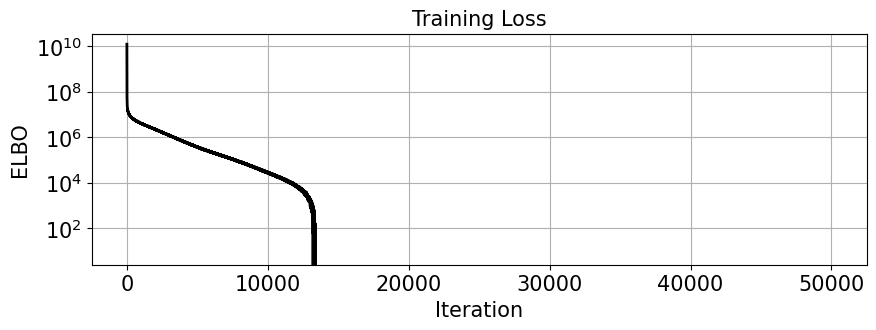

In [88]:
# %% Visualization
visualizations.plot_loss(
    [guide.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


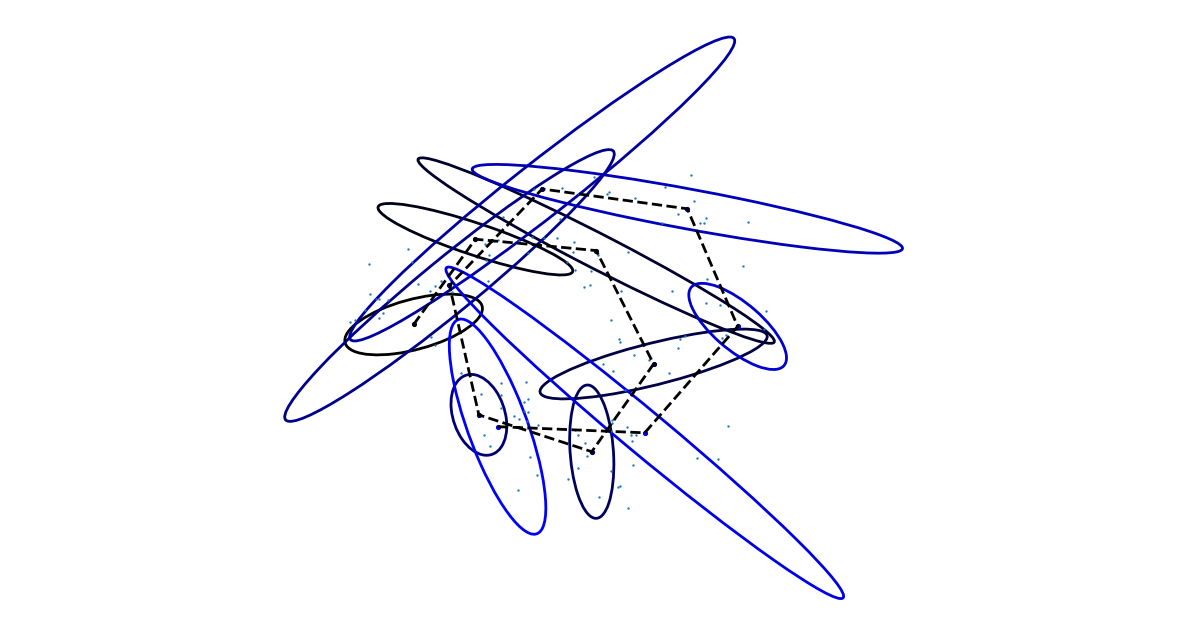

In [96]:
# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1),std=1
)

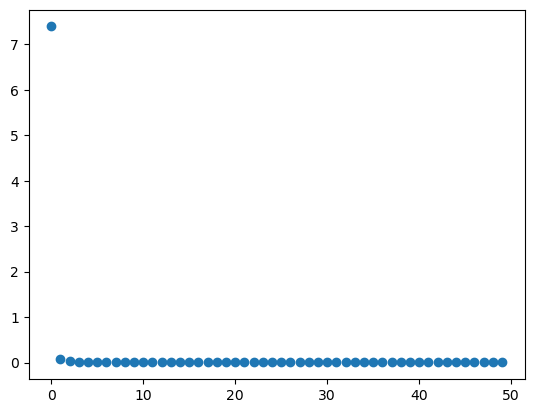

In [92]:
evals_store = np.zeros((12,50))
sigma_hat.shape
for iangle in range(12):
    cov_matrix = sigma_hat[iangle,:,:]
    eval, evec = np.linalg.eigh(cov_matrix)
    non_zero_evals = eval[::-1]
    evals_store[iangle,:] = non_zero_evals[:50]
    # plt.scatter(np.arange(len(non_zero_evals)), non_zero_evals)
    # plt.title(f'Angle {iangle}')
    # plt.show()
average_evals = np.mean(evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_evals)), average_evals)





(0.0, 0.5)

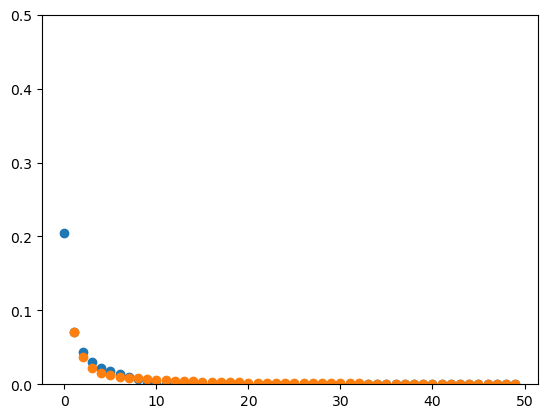

In [95]:
TEST_RESPONSE.shape
raw_evals_store = np.zeros((12,50))
for iangle in range(12):
    test = TEST_RESPONSE[:,iangle,:]  # shape (K, N)
    covariance_matrix = np.cov(test, rowvar=False)  # shape (N, N)
    eval, evec = np.linalg.eigh(covariance_matrix)
    non_zero_evals = eval[::-1]
    raw_evals_store[iangle,:] = non_zero_evals[:50]
average_raw_evals = np.mean(raw_evals_store, axis=0)#[1:]
plt.scatter(np.arange(len(average_raw_evals)), average_raw_evals)
plt.scatter(np.arange(len(average_evals)), average_evals)
plt.ylim(0,0.5)

